# Segmenting Retinal Blood Vessels

Tworzymy klasy pomocnicze:
- ProcessImage - statyczna klasa zajmująca się przetwarzaniem obrazu
- Classifier - klassa wykorzystująca  biblioteki do predykcji położenia naczyń na obrazie

In [35]:
import math
import cv2
from sklearn.neighbors import KNeighborsClassifier
from processImage import ProcessImage
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from skimage import morphology
from IPython.display import display
from PIL import Image
from skimage.feature import local_binary_pattern
import mahotas
from skimage.filters import frangi

In [36]:
class ProcessImage:

    def slice_img(src_img, size, all=True):
        slices = []
        if all:
            for x in range(size - 1, src_img.shape[0] - size, 1):
                for y in range(size - 1, src_img.shape[1] - size, 1):
                    slices.append(src_img[x:x+size, y:y+size])
        else:
            for x in range(size - 1, src_img.shape[0] - size, 5):
                for y in range(size - 1, src_img.shape[1] - size, 5):
                    slices.append(src_img[x:x+size, y:y+size])

        return slices

    def get_hu(src_img_part):
        moments = cv2.moments(src_img_part)
        huMoments = cv2.HuMoments(moments)
        # Log scale hu moments
        for i in range(0, 7):
            if huMoments[i] != 0:
                huMoments[i] = -1 * math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

        flat_huMoments = [item for sublist in huMoments for item in sublist]
        return flat_huMoments

    def extract_green(src_img):
        _, green_channel, _ = cv2.split(src_img)  # split img into 3 channels: blue, green, red
        return green_channel

    def resize_img(src_img, scale=1.0):
        if scale != 1.0:
            h, w, _ = src_img.shape
            h = int(h * scale)
            w = int(w * scale)
            resized_img = cv2.resize(src_img, (w, h), interpolation=cv2.INTER_LINEAR)
            return resized_img
        else:
            return src_img

    def min_max_snap(src_img, limit=7.):
        w, h = src_img.shape
        new_img = np.zeros_like(src_img)
        for i in range(w):
            for j in range(h):
                # img[i][j] = int(img[i][j] * 255)
                new_img[i][j] = 255 if src_img[i][j] > limit else 0

        return new_img

    def prepare_mask(src_img, border_size=3):
        mask = ProcessImage.min_max_snap(src_img, limit=1)
        kernel = np.ones((border_size, border_size), np.uint8)
        mask = cv2.erode(mask, kernel, iterations=1)
        return mask

    def preprocess(src_img):
        img = ProcessImage.resize_img(src_img.copy(), scale=1.0)
        img = ProcessImage.extract_green(img)

        mask = ProcessImage.prepare_mask(img, border_size=5)

        # blurowanie które pozostawia krawedzie ostre, przynajmniej w zalożeniach bo nie widzialem zmiany
        img = cv2.bilateralFilter(img, 9, 11, 11)

        # zwiększenie kontrastu
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(9, 9))
        img = clahe.apply(img)

        return mask, img


In [37]:
class Classifier:
    def __init__(self, trainImages_x, trainImages_y, n_neighbors=11, sliceSize=5):
        self.sliceSize = sliceSize
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
        self.x_train, self.y_train = [], []
        print('Iterating through train images')

        # slice obrazu oraz obliczanie hu momentów dla każdej jego części
        for img in trainImages_x:
            img_sliced = ProcessImage.slice_img(img, self.sliceSize, all=False)
            for img_part in img_sliced:
                x = np.array([])

                huMoments = ProcessImage.get_hu(img_part)
                x = np.append(x, huMoments)

                # lbp = local_binary_pattern(img_part, 8*5, 5, method='ror')
                # lbp = sum(lbp)
                # x = np.append(x, lbp)

                # var = math.sqrt(np.var(img_part))
                # x = np.append(x, var)

                zm = mahotas.features.zernike_moments(img_part, sliceSize)
                zm = np.array([zm[2], zm[4], zm[6], zm[12], zm[20]])
                x = np.append(x, zm)

                self.x_train.append(x)
                if len(self.x_train) % 1000 == 0:
                    print(len(self.x_train))

        print('Iterating through train expert images')
        # slice obrazu eksperckiego i wybieranie jego centralnego punktu
        for img in trainImages_y:
            img_sliced = ProcessImage.slice_img(img, self.sliceSize, all=False)
            for img_part in img_sliced:
                center_pixel = img_part[self.sliceSize//2][self.sliceSize//2]
                self.y_train.append(center_pixel)

        print('Undersampling...')
        rus = RandomUnderSampler(random_state=0)
        self.x_train, self.y_train = rus.fit_resample(self.x_train, self.y_train)

        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        print('Training...')
        self.model.fit(self.x_train, self.y_train)

    def predict(self, predictImage):
        print('Preparing predict image')
        img_sliced = ProcessImage.slice_img(predictImage, self.sliceSize)
        testCases = []
        for img_part in img_sliced:
            x = np.array([])

            huMoments = ProcessImage.get_hu(img_part)
            x = np.append(x, huMoments)

            # lbp = local_binary_pattern(img_part, 8*5, 5, method='ror')
            # lbp = sum(lbp)
            # x = np.append(x, lbp)

            # var = math.sqrt(np.var(img_part))
            # x = np.append(x, var)

            zm = mahotas.features.zernike_moments(img_part, self.sliceSize)
            zm = np.array([zm[2], zm[4], zm[6], zm[12], zm[20]])
            x = np.append(x, zm)

            testCases.append(x)

        print('Predicting...')
        y_pred = self.model.predict(testCases)
        print('Predicted.')
        predicted_image = np.zeros_like(predictImage)
        i = 0
        for x in range(self.sliceSize - 1, predictImage.shape[0] - self.sliceSize, 1):
            for y in range(self.sliceSize - 1, predictImage.shape[1] - self.sliceSize, 1):
                predicted_image[x, y] = y_pred[i]
                i += 1
        cv2.imwrite('temp.jpg', predicted_image)
        return predicted_image

Funkcja oceniająca jakość predykcji:

In [38]:
def evaluate(prediction, true_model, imbalanced_data=False):
    if prediction.shape != true_model.shape:
        return -1
    if len(prediction.shape) != 2:
        return -2
    h, w = prediction.shape
    conf_image = np.zeros((h, w, 3))

    TP, FP, FN, TN = 0, 0, 0, 0
    for r in range(w):
        for c in range(h):
            if prediction[c][r] == true_model[c][r] == 255:
                TP += 1
                conf_image[c][r] = 255, 255, 255
            elif prediction[c][r] == true_model[c][r] == 0:
                TN += 1
                conf_image[c][r] = 0, 0, 0
            elif prediction[c][r] != true_model[c][r] and prediction[c][r] == 255:
                FP += 1
                conf_image[c][r] = 0, 0, 255  # BGR
            elif prediction[c][r] != true_model[c][r] and prediction[c][r] == 0:
                FN += 1
                conf_image[c][r] = 0, 255, 0  # BGR
            else:
                print(prediction[c][r], true_model[c][r])
                return -3

    accuracy = (TP+TN)/(TP+TN+FN+FP)
    sensitivity = TP/(TP+FN)
    specifity = TN/(FP+TN)
    try:
        precision = TP/(TP+FP)
    except:
        print('No positive values found')
        return np.zeros_like(prediction.shape)
    f = open('measures.txt', 'w')
    
    f.write('Accuracy: ' + str(accuracy) + '\n')
    f.write('Sensitivity: ' + str(sensitivity) + '\n')
    f.write('Specifity: ' + str(specifity) + '\n')
    f.write('Precision: ' + str(precision) + '\n')
    if imbalanced_data:
        f.write('G-Mean: ' + str(math.sqrt(sensitivity*specifity)) + '\n')
        f.write('F-measure: ' + str((2*precision*sensitivity)/(precision+sensitivity)) + '\n')
    f.close()
    return conf_image


Główne funkcje: 
- classificator_vessel_detection - główna funkcjonalność 

- naive_vessel_detection - aktualnie niewykorzystywana funkcja do generowania predykcji w sposób naiwny

- naive_process_image - funkcja pomocnicza do naive_vessel_detection

In [39]:
def naive_process_image(img, scale=1.0):
    processed_img = ProcessImage.resize_img(img.copy(), scale)
    _, green_channel, _ = cv2.split(processed_img)  # split img into 3 channels: blue, green, red

    mask = ProcessImage.prepare_mask(green_channel, 5)  # prepare mask to remove outer circle from image

    processed_img = cv2.medianBlur(green_channel, 7)

    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(7, 7))
    processed_img = clahe.apply(processed_img)
    cv2.imwrite('preprocessed.jpg', processed_img)

    processed_img = (frangi(processed_img, gamma=0.8, beta=0.15))
    processed_img = (processed_img * 255).astype(np.uint8)
    cv2.imwrite('processed.jpg', processed_img)

    processed_img = cv2.medianBlur(processed_img, 3)
    processed_img = ProcessImage.min_max_snap(processed_img, 35)

    processed_img = np.array(processed_img, bool)
    processed_img = morphology.remove_small_objects(processed_img, min_size=128)
    processed_img = processed_img * 255
    processed_img = processed_img.astype('uint8')

    kernel = np.ones((5, 5), np.uint8)
    processed_img = cv2.morphologyEx(processed_img, cv2.MORPH_CLOSE, kernel)

    processed_img = cv2.bitwise_and(processed_img, processed_img, mask=mask)
    processed_img = processed_img.astype(np.uint8)
    cv2.imwrite('postprocessed.jpg', processed_img)
    return processed_img


def naive_vessel_detection(image_no=5):
    input_img_path = 'data/Image_{:02d}L.jpg'.format(image_no)
    input_img = cv2.imread(input_img_path)
    output_image = naive_process_image(input_img)

    expert_img_path = 'goal/Image_{:02d}L_1stHO.png'.format(image_no)
    expert_img = cv2.imread(expert_img_path, cv2.IMREAD_GRAYSCALE)
    confusion_img = evaluate(output_image, expert_img, imbalanced_data=True)

    model_img_rgb = cv2.cvtColor(expert_img,
                                 cv2.COLOR_GRAY2BGR)  # while concatenating all arrays have to have same dimension

    prediction_img_rgb = cv2.cvtColor(output_image.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    cv2.imwrite('confusion_img.jpg', confusion_img)
    cv2.imwrite('expert_img.jpg', expert_img)
    cv2.imwrite('prediction.jpg', output_image)

    images = np.concatenate((prediction_img_rgb, model_img_rgb, confusion_img), axis=1)
    cv2.namedWindow('images', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('images', 1800, 600)
    cv2.imshow('images', images)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


def classificator_vessel_detection(image_no=5, training_set=4, use_previous=False):
    training_set = range(1, training_set+1)

    train_imgs = []
    expert_imgs = []
    for training_no in training_set:
        train_img_path = 'data/Image_{:02d}L.jpg'.format(training_no)
        train_img = cv2.imread(train_img_path)
        _, train_img = ProcessImage.preprocess(train_img)
        train_imgs.append(train_img)

        expert_img_path = 'goal/Image_{:02d}L_1stHO.png'.format(training_no)
        expert_img = cv2.imread(expert_img_path, cv2.IMREAD_GRAYSCALE)

        expert_imgs.append(expert_img)

    predict_img_path = 'data/Image_{:02d}L.jpg'.format(image_no)
    predict_img = cv2.imread(predict_img_path)
    mask, predict_img = ProcessImage.preprocess(predict_img)
    cv2.imwrite('preprocessed.jpg', predict_img)

    expert_img_path = 'goal/Image_{:02d}L_1stHO.png'.format(image_no)
    expert_predict_img = cv2.imread(expert_img_path, cv2.IMREAD_GRAYSCALE)

    if use_previous:
        y_pred = cv2.imread('temp.jpg', cv2.IMREAD_GRAYSCALE)
        ret, y_pred = cv2.threshold(y_pred, 127, 255, cv2.THRESH_BINARY)
    else:
        classifier = Classifier(trainImages_x=train_imgs, trainImages_y=expert_imgs)
        y_pred = classifier.predict(predict_img)

    cv2.imwrite('processed.jpg', y_pred)

    y_pred = np.array(y_pred, bool)
    y_pred = morphology.remove_small_objects(y_pred, min_size=64)
    y_pred = y_pred * 255
    y_pred = y_pred.astype('uint8')
    kernel = np.ones((5, 5), np.uint8)
    y_pred = cv2.morphologyEx(y_pred, cv2.MORPH_CLOSE, kernel)

    # apply mask
    y_pred = cv2.bitwise_and(y_pred, y_pred, mask=mask)
    y_pred = y_pred.astype(np.uint8)
    cv2.imwrite('postprocessed.jpg', y_pred)

    confusion_img = evaluate(y_pred, expert_predict_img, imbalanced_data=True)
    model_img_rgb = cv2.cvtColor(expert_predict_img,
                                 cv2.COLOR_GRAY2BGR)  # while concatenating all arrays have to have same dimension
    cv2.imwrite('confusion_img.jpg', confusion_img)
    cv2.imwrite('expert_img.jpg', expert_predict_img)
    cv2.imwrite('prediction.jpg', y_pred)
    prediction_img_rgb = cv2.cvtColor(y_pred.astype(np.uint8), cv2.COLOR_GRAY2BGR)


    images = np.concatenate((prediction_img_rgb, model_img_rgb, confusion_img), axis=1)
    cv2.imwrite('final.jpg', images)
    images = np.concatenate((Image.open('preprocessed.jpg'), Image.open('processed.jpg'), Image.open('postprocessed.jpg')), axis=1)
    cv2.imwrite('processed.jpg', images)


# naive_vessel_detection(10)
classificator_vessel_detection(10, training_set=5, use_previous=False)


Iterating through train images
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000

Pierwsze trzy grafiki przedstawiają kolejne etapy obróbki obrazu.

Następne trzy przedstawiają kolejno uzyskany obraz, oczekiwany obraz i różnicę między nimi.

preprocessed                                                       processed                                                                postprocessed


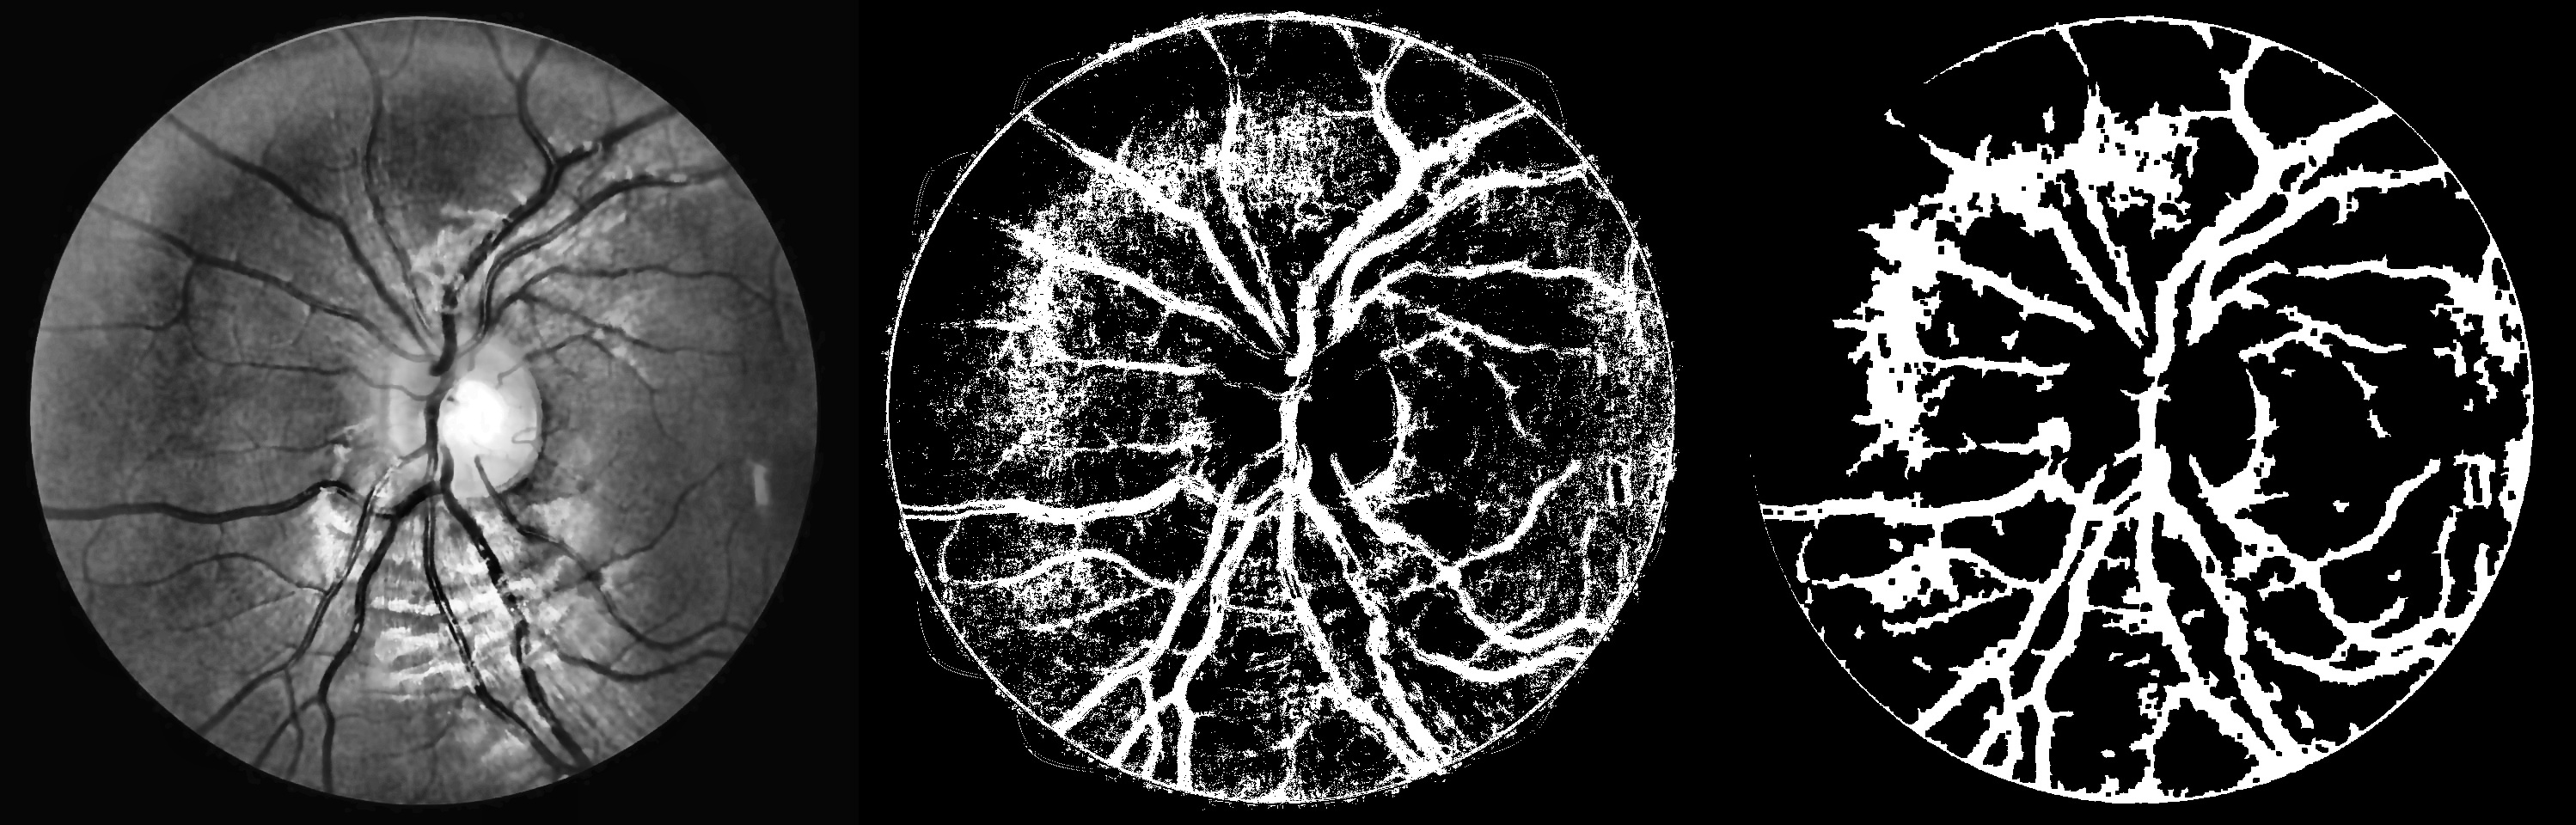

predicted                                                          expected                                                                 confusion


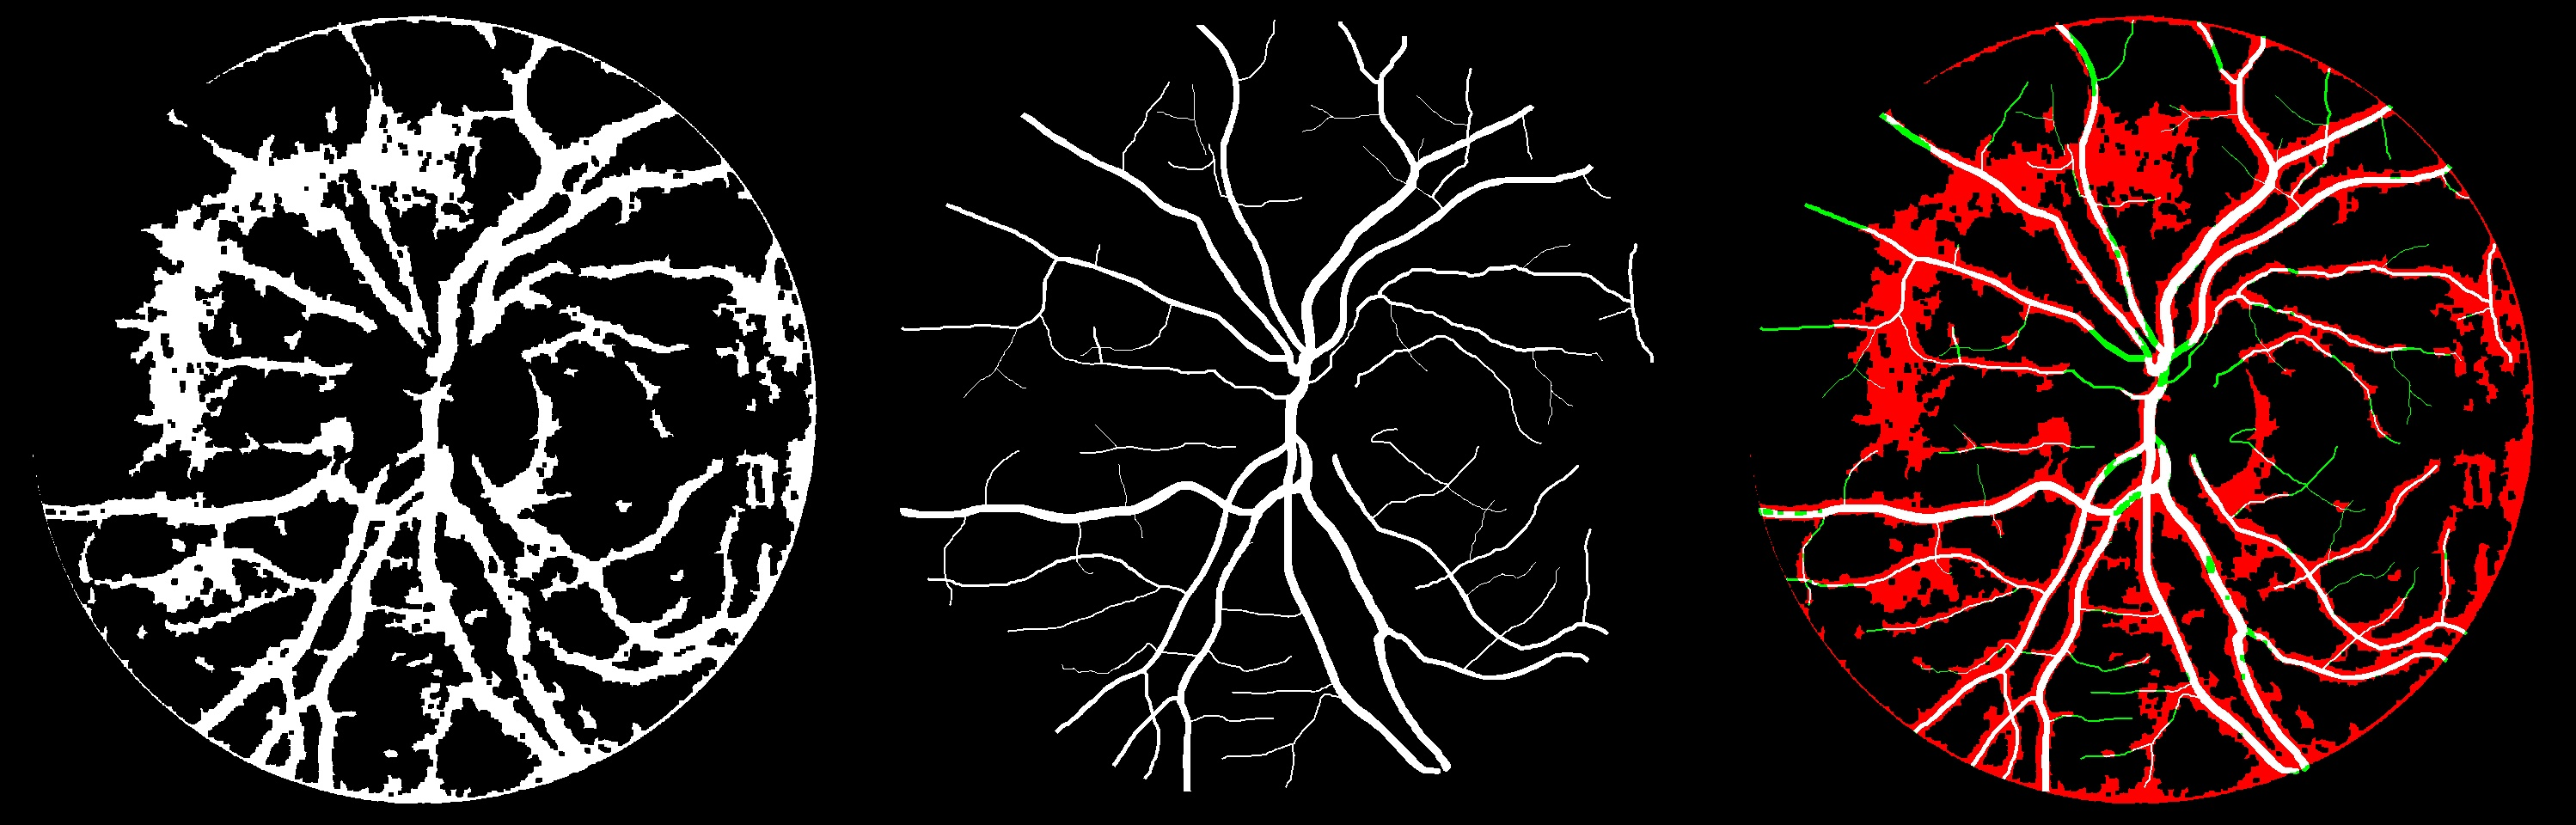

Accuracy: 0.8420660243576911
Sensitivity: 0.8447965909847527
Specifity: 0.8418835459484473
Precision: 0.2631095996225887
G-Mean: 0.8433388106943754
F-measure: 0.401250746138855



In [43]:
print('preprocessed                                                       processed                                                                postprocessed')
display(Image.open('processed.jpg'))
print('predicted                                                          expected                                                                 confusion')
display(Image.open('final.jpg'))
f = open('measures.txt')
print(f.read())
f.close()
